<div class="alert alert-info">
    <h1>Analysis of Saturn's F Ring During the Cassini Mission</h1>
    <h1>Compute the F Ring's Phase Curve and Look for Time Variation</h1>

Robert S. French, rfrench@seti.org - Last updated April 10, 2024

Research performed under NASA Grant 80NSSC21K0527 for CDAP proposal "The Recent History of Saturn's Dusty Rings".
</div>


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..'); sys.path.append('../external')
    
from f_ring_util.f_ring import (add_hover,
                                compute_corrected_ew, 
                                fit_hg_phase_function, 
                                hg_func,
                                limit_by_quant,
                                print_hg_params,
                                read_ew_stats,
                                scale_hg_phase_function)

%matplotlib widget
mpl.rcParams['figure.max_open_warning'] = 100

# Utility Functions

In [2]:
### SINGLE PLOTS - POINTS

def plot_various_quants(obsdata, include_phase=True):
    """Choose various quantiles of NormalEW and plot w/phase curves."""
    print('Params: All points / Mean of Observation group')
    fig, axs = plt.subplots(6, 2, figsize=(10, 12))
    for plot_num, (perc1, perc2, color) in enumerate(((100, None, 'black'),
                                                      ( 90, None, 'black'),
                                                      ( 80, None, 'black'),
                                                      ( 70, None, 'black'),
                                                      ( 60, None, 'black'),
                                                      ( 50, None, 'black'),
                                                      ( 40, None, 'black'),
                                                      ( 30, None, 'black'),
                                                      ( 20, None, 'black'),
                                                      ( 10, None, 'black'),
                                                      ( 80,   20, 'blue'),
                                                      ( 70,   30, 'blue'))):
        ax = axs[plot_num // 2, plot_num % 2]
        quant_obsdata = limit_by_quant(obsdata, perc1, perc2)
        ax.scatter(quant_obsdata['Mean Phase'], quant_obsdata['Normal EW Mean'], marker='o', 
                   s=5, color=color, alpha=1)
        title = f'{perc1} / {perc2}'
        if include_phase:
            params, _, _ = fit_hg_phase_function(2, None, quant_obsdata)
            xrange = np.arange(quant_obsdata['Mean Phase'].min(), quant_obsdata['Mean Phase'].max()+1)
            full_phase_model = hg_func(params, xrange)
            lcolor = 'black' if color != 'black' else 'green'
            total_scale = params[1] + params[3]
            w1 = params[1] / total_scale
            w2 = params[3] / total_scale
            if params[1] < params[3]:
                title  += f' (g1 = {params[2]:6.3f} @ {w2:5.3f} / g2 = {params[0]:6.3f})'
            else:
                title  += f' (g1 = {params[0]:6.3f} @ {w1:5.3f} / g2 = {params[2]:6.3f})'
            ax.plot(xrange, full_phase_model, '-', color=lcolor, lw=3)
            quant_obsdata_mean = quant_obsdata.groupby('Observation').mean(numeric_only=True)
            params_mean, _, _ = fit_hg_phase_function(2, None, quant_obsdata_mean)
            print(f'*** {perc1} / {perc2}: {color}')
            print_hg_params(params)
            print_hg_params(params_mean)
        ax.set_yscale('log')
        ax.set_xlim(0, 180)
        ax.set_xlabel('Phase Angle (°)')
        ax.set_ylabel('Normal EW')
        ax.set_title(title)
    plt.tight_layout()
    
    
### SINGLE PLOTS ON AN AXIS - PHASE CURVE

def _standard_alpha(obsdata):
    """Return alpha based on number of points to plot."""
    if len(obsdata) < 1000:
        return 1
    elif len(obsdata) < 10000:
        return 0.6
    else:
        return 0.3
        
def plot_points_phase_curve(obsdata, params, used_obsdata=None, title=None, 
                            col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered used/unused EW points and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    
    if used_obsdata is not None:
        used_obsdata['Phase Model'] = hg_func(params, used_obsdata['Mean Phase'])
        obsdata['_alpha'] = 0.1
        obsdata['_color'] = 'red'
        obsdata.loc[used_obsdata.index, '_alpha'] = 0.3
        obsdata.loc[used_obsdata.index, '_color'] = 'black'
    else:
        obsdata['_alpha'] = 0.3
        obsdata['_color'] = 'black'
        
    p = ax.scatter(obsdata['Mean Phase'], obsdata[col], marker='o', 
                   s=5, color=obsdata['_color'], alpha=obsdata['_alpha'])
    add_hover(obsdata, p)

    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax.set_yscale('log')
    ax.set_xlim(0, 180)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_heatmap_phase_curve(obsdata, params, title=None, col='Normal EW Mean', ax=None, **kwargs):
    """Plot binned heatmap and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    ymin = obsdata[col].min()
    ymax = obsdata[col].max()
    heatmap, xedges, yedges = np.histogram2d(obsdata['Mean Phase'],
                                             np.log10(obsdata[col]),
                                             bins=(90, 50),
                                             range=[[0,180], [np.log10(ymin), np.log10(ymax)]])
    heatmap = heatmap ** .25
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T[::-1,:], extent=extent, cmap=cm.Greys, interpolation='nearest', aspect='auto')
    
    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, np.log10(full_phase_model), '-', color='green', lw=2)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_points_phase_time(obsdata, params, title=None, time_fit=3, col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered EW points by time with fit time curve colored by phase."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    time0 = np.datetime64('1970-01-01T00:00:00') # epoch
    obsdata['Date_secs'] = (obsdata['Date']-time0).dt.total_seconds()/86400
    obsdata['Phase Curve Ratio'] = obsdata[col] / obsdata['Phase Model']
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata['Date'], obsdata['Phase Curve Ratio'], marker='o', s=5,
                   c=obsdata['Mean Phase'], cmap=cm.jet, alpha=alpha)
    add_hover(obsdata, p)

    timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], time_fit)
    timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
    timefit = np.polyval(timecoeff, timerange)
    ax.plot(timerange, timefit, '-', lw=2, color='green')
    ax.set_yscale('log')
    ax.set_xlabel('Date of Observation')
    ax.set_ylabel(f'{col} / Full Phase Model')
    if title is not None:
        plt.title(title)

    
### COMBINED PLOTS
    
def plot_points_phase_curve_time(obsdata, params, title, used_obsdata=None, time_fit=3, **kwargs):
    """Plot 1) scatter+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_points_phase_curve(obsdata, params, used_obsdata=used_obsdata, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()
    
def plot_heatmap_phase_curve_time(obsdata, params, title, time_fit=3, **kwargs):
    """Plot 1) heatmap+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_heatmap_phase_curve(obsdata, params, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()

In [3]:
obsdata_60_0 = read_ew_stats('../data_files/cass_ew_60_0.csv',
                             obslist_filename='CASSINI_OBSERVATION_LIST',
                             obslist_column='For Photometry')
print()
obsdata_0_1 = read_ew_stats('../data_files/cass_ew_0_1.csv',
                            obslist_filename='CASSINI_OBSERVATION_LIST',
                            obslist_column='For Photometry')
obsdata_0_1_mean = obsdata_0_1.groupby('Observation').mean(numeric_only=True)

** SUMMARY STATISTICS - ../data_files/cass_ew_60_0.csv **
Unique observation names: 157
Total slices: 157
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39

** SUMMARY STATISTICS - ../data_files/cass_ew_0_1.csv **
Unique observation names: 212
Total slices: 39129
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 21:51:55
Time span: 4827 days 02:36:27


# Phase Curves for Various Quantiles

Params: All points / Mean of Observation group
*** 100 / None: black
g1 =  0.676 / scale1 =  1.566 / weight1 = 0.613 
g2 =  0.048 / scale2 =  0.988 / weight2 = 0.387  Avg scale 1.277
g1 =  0.687 / scale1 =  1.597 / weight1 = 0.607 
g2 =  0.049 / scale2 =  1.036 / weight2 = 0.393  Avg scale 1.317
*** 90 / None: black
g1 =  0.676 / scale1 =  1.519 / weight1 = 0.623 
g2 =  0.038 / scale2 =  0.920 / weight2 = 0.377  Avg scale 1.219
g1 =  0.685 / scale1 =  1.560 / weight1 = 0.624 
g2 =  0.036 / scale2 =  0.941 / weight2 = 0.376  Avg scale 1.251
*** 80 / None: black
g1 =  0.676 / scale1 =  1.491 / weight1 = 0.630 
g2 =  0.032 / scale2 =  0.877 / weight2 = 0.370  Avg scale 1.184
g1 =  0.684 / scale1 =  1.538 / weight1 = 0.633 
g2 =  0.030 / scale2 =  0.893 / weight2 = 0.367  Avg scale 1.216
*** 70 / None: black
g1 =  0.676 / scale1 =  1.470 / weight1 = 0.637 
g2 =  0.026 / scale2 =  0.839 / weight2 = 0.363  Avg scale 1.154
g1 =  0.682 / scale1 =  1.523 / weight1 = 0.642 
g2 =  0.023 / scale2 

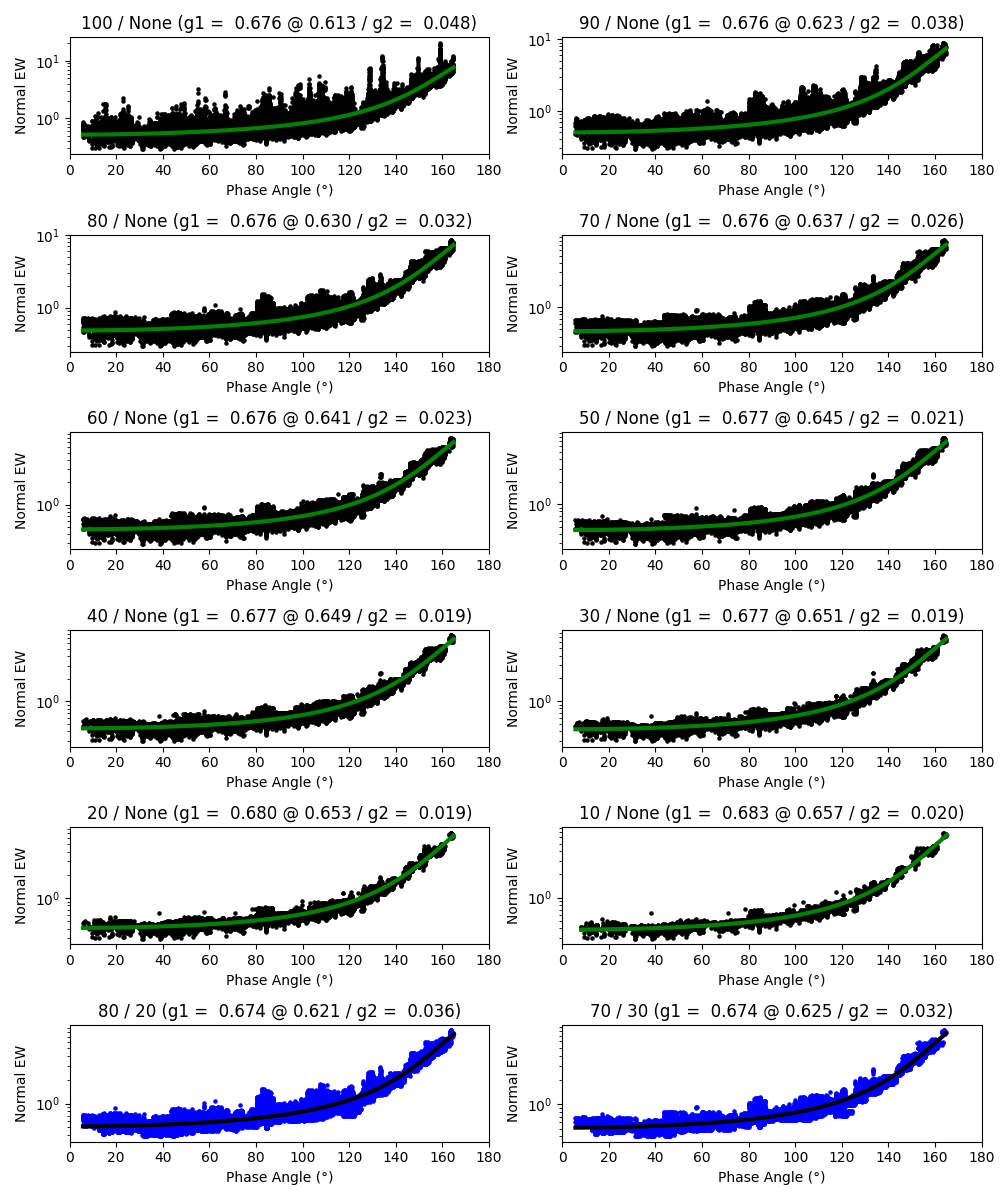

In [4]:
plot_various_quants(obsdata_0_1)

<div class="alert alert-info">
<h2>Analysis</h2>

<b>Regardless of the outliers removed, the F Ring phase curve during Cassini has a primary component of g1 around 0.65. The secondary component g2 varies from -0.031 to 0.032. This compares to the Charming Ringlet (Hedman & Bridges 2020) with g1=0.643, g2=-0.247 and the G Ring (Hedman & Stark 2015) with g2=0.665, g3=0.035.</b>
</div>


# Check for Time Variation

Cutoff 100 / None, 1 Degree Slices
g1 =  0.676 / scale1 =  1.566 / weight1 = 0.613 
g2 =  0.048 / scale2 =  0.988 / weight2 = 0.387  Avg scale 1.277


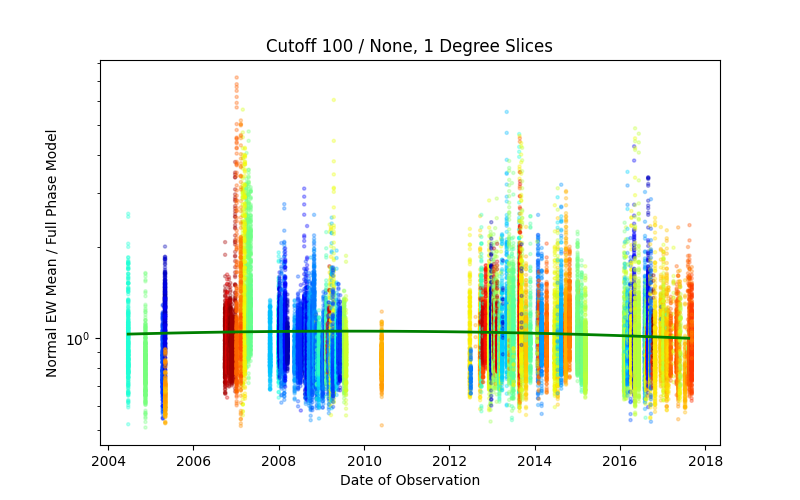

In [5]:
cutoff1 = 100
cutoff2 = None
obsdata_limited = limit_by_quant(obsdata_0_1, cutoff1, cutoff2)
params_limited, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
title = f'Cutoff {cutoff1} / {cutoff2}, 1 Degree Slices'
print(title)
print_hg_params(params_limited)
plot_points_phase_time(obsdata_limited, params_limited, title=title, time_fit=2)

Cutoff 100 / None, Full Slices
g1 =  0.681 / scale1 =  1.577 / weight1 = 0.602 
g2 =  0.066 / scale2 =  1.042 / weight2 = 0.398  Avg scale 1.309


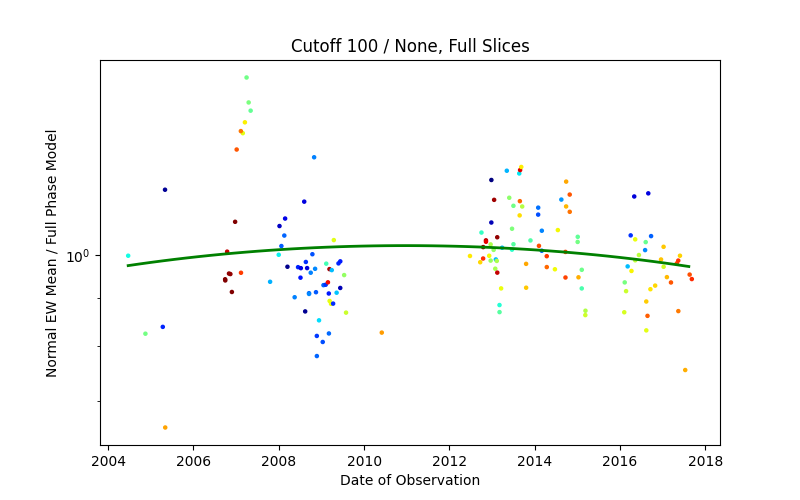

In [6]:
cutoff1 = 100
cutoff2 = None
obsdata_limited = limit_by_quant(obsdata_60_0, cutoff1, cutoff2)
params_limited, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
title = f'Cutoff {cutoff1} / {cutoff2}, Full Slices'
print(title)
print_hg_params(params_limited)
plot_points_phase_time(obsdata_limited, params_limited, title=title, time_fit=2)

Cutoff 50 / None, 1 Degree Slices
g1 =  0.677 / scale1 =  1.423 / weight1 = 0.645 
g2 =  0.021 / scale2 =  0.782 / weight2 = 0.355  Avg scale 1.102


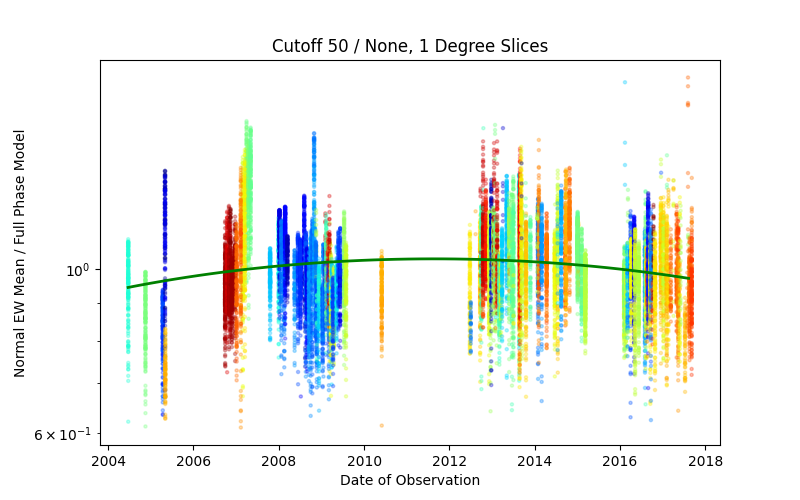

In [7]:
cutoff1 = 50
cutoff2 = None
obsdata_limited = limit_by_quant(obsdata_0_1, cutoff1, cutoff2)
params_limited, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
title = f'Cutoff {cutoff1} / {cutoff2}, 1 Degree Slices'
print(title)
print_hg_params(params_limited)
plot_points_phase_time(obsdata_limited, params_limited, title=title, time_fit=2)

<div class="alert alert-info">
<h2>Conclusion</h2>

<b>There is no evidence of time variability in the F ring during the Cassini mission.</b>
</div>
